In [13]:
import requests
from datetime import datetime, timedelta
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
match_df = pd.read_csv('pro_match_ids_march_2023.csv')
match_ids = match_df['Match ID'].tolist()

In [5]:
# set up API URL and parameters
api_url = 'https://api.opendota.com/api/matches/{}/'

# initialize empty list to store results
results = []
max_attempts = 3

# loop through match IDs and retrieve relevant data
for match_id in match_ids[:500]:
    # send GET request to API
    response = requests.get(api_url.format(match_id))
    
    # initialize number of attempts to 0
    num_attempts = 0
    while num_attempts < max_attempts:

        # check if request was successful
        if response.status_code == 200:
            # extract relevant data from response JSON
            data = response.json()
            players = data['players']

            # loop through each player in the match and extract relevant data
            for player in players:
                hero_id = player['hero_id']
                player_slot = player['player_slot']
                team = 'Radiant' if player_slot < 128 else 'Dire'
                lane_start = player['lane']
                lane_pos = player['lane_pos']
                # add data to results list
                results.append({
                    'match_id': match_id,
                    'hero_id': hero_id,
                    'player_slot': player_slot,
                    'team': team,
                    'lane_start': lane_start,
                    'lane_pos': lane_pos
                })
            break
        else:
            print(f"Error retrieving data for match ID {match_id}.")
            num_attempts += 1
            time.sleep(60)
            
    if num_attempts == max_attempts:
        print(f"Unable to retrieve data from OpenDota API for match ID {match_id}. Moving on to next match.")

    # print progress every 100 matches
    if len(results) % 1000 == 0:
        print(f"Processed data for {len(results)} players in {len(results)/10} matches.")

    # break loop if we have processed data for 100000 players
#     if len(results) >= 100000:
#         break

non_retrieved_data = match_ids[500:]

# convert results to pandas DataFrame
players_df = pd.DataFrame(results)
players_df.head()

Error retrieving data for match ID 7082573416.
Error retrieving data for match ID 7082573416.
Error retrieving data for match ID 7082573416.
Unable to retrieve data from OpenDota API for match ID 7082573416. Moving on to next match.
Processed data for 1000 players in 100.0 matches.
Error retrieving data for match ID 7081100552.
Error retrieving data for match ID 7081100552.
Error retrieving data for match ID 7081100552.
Unable to retrieve data from OpenDota API for match ID 7081100552. Moving on to next match.
Processed data for 2000 players in 200.0 matches.
Error retrieving data for match ID 7079820802.
Error retrieving data for match ID 7079820802.
Error retrieving data for match ID 7079820802.
Unable to retrieve data from OpenDota API for match ID 7079820802. Moving on to next match.
Error retrieving data for match ID 7079017855.
Error retrieving data for match ID 7079017855.
Error retrieving data for match ID 7079017855.
Unable to retrieve data from OpenDota API for match ID 70790

,hero_id,lane_pos,lane_start,match_id,player_slot,team
0,70,"{'72': {'78': 4}, '74': {'74': 1}, '76': {'76'...",1,7083727502,0,Radiant
1,120,"{'70': {'78': 6}, '72': {'78': 2, '80': 6}, '7...",2,7083727502,1,Radiant
2,33,"{'70': {'140': 18, '142': 3}, '72': {'78': 1, ...",3,7083727502,2,Radiant
3,86,"{'70': {'138': 1, '140': 1, '142': 1}, '72': {...",2,7083727502,3,Radiant
4,75,"{'72': {'78': 5, '80': 1}, '74': {'74': 3, '76...",1,7083727502,4,Radiant


In [8]:
players_df.to_csv('lane_data.csv', index=False)

In [58]:
lane_pos = players_df['lane_pos']

print(lane_pos)

0       {'72': {'78': 4}, '74': {'74': 1}, '76': {'76'...
1       {'70': {'78': 6}, '72': {'78': 2, '80': 6}, '7...
2       {'70': {'140': 18, '142': 3}, '72': {'78': 1, ...
3       {'70': {'138': 1, '140': 1, '142': 1}, '72': {...
4       {'72': {'78': 5, '80': 1}, '74': {'74': 3, '76...
5       {'74': {'138': 3, '140': 1, '142': 1}, '76': {...
6       {'76': {'132': 3, '134': 7}, '78': {'134': 2, ...
7       {'82': {'166': 1}, '84': {'164': 1}, '86': {'1...
8       {'72': {'144': 7}, '74': {'144': 4}, '76': {'1...
9       {'120': {'156': 1}, '122': {'154': 3, '156': 1...
10      {'70': {'74': 1}, '72': {'76': 1}, '74': {'74'...
11      {'74': {'76': 2, '80': 1, '138': 1, '140': 1, ...
12      {'72': {'78': 10}, '74': {'76': 5, '78': 2}, '...
13      {'72': {'78': 1}, '74': {'76': 1, '78': 1, '80...
14      {'72': {'78': 2}, '74': {'78': 1}, '76': {'78'...
15      {'76': {'154': 2, '156': 1, '158': 1, '164': 1...
16      {'84': {'166': 1}, '88': {'168': 1}, '106': {'...
17      {'96':

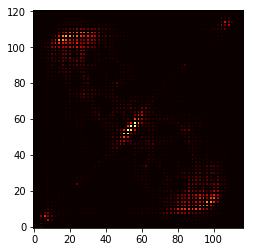

In [57]:
# make heat map with lane data

# initialize empty dictionary to hold aggregated lane data
agg_data = {}

# iterate over each player's dictionary and add up the seconds spent at each (x,y) location
for player_data in lane_pos:
    for x, y_dict in player_data.items():
        x = int(x)
        for y, seconds in y_dict.items():
            y = int(y)
            if x not in agg_data:
                agg_data[x] = {}
            if y not in agg_data[x]:
                agg_data[x][y] = 0
            agg_data[x][y] += seconds

# Get map bounds 
min_x = min(agg_data.keys())
max_x = max(agg_data.keys())
min_y = min(min(y.keys()) for y in agg_data.values())
max_y = max(max(y.keys()) for y in agg_data.values())

# Create a zero array with shape of map
heatmap_data = np.zeros((max_x - min_x + 1, max_y - min_y + 1))

# Fill in the array with the lane data
for x, y_dict in agg_data.items():
    for y, seconds in y_dict.items():
        heatmap_data[x - min_x, y - min_y] = seconds

# Plot the heatmap
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')
plt.show()